In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
import gc

# Reading phycon file

In [2]:
phycon_data = readsav('phycon.sav')
phycon_data

{'tko': 273.15,
 'po': 100000.0,
 'r': 8.3144,
 'rd': 287.05,
 'rv': 461.51,
 'epsilon': 0.622,
 'cpd': 1005.2,
 'cpv': 1870.4,
 'cl': 4218.0,
 'ci': 2106.0,
 'lvo': 2500800.0,
 'lso': 2834500.0,
 'g': 9.81}

# Atmospheric Sounding data

In [3]:
sounding_data = pd.read_csv('20220912_1655.csv',  encoding= 'unicode_escape')
sounding_data

,Time [sec],P [hPa],T [°C],Hu [%],Ws [m/s],Wd [°],Ws U [m/s],Ws V [m/s],Alt [m],Lon [°],Lat [°],Dew [°C]
0,0,787.0,21.6,22,0.0,0,0.0,0.0,2200,-105.581200,41.313200,9.6
1,1,786.4,21.2,21,0.1,3,0.0,-0.1,2207,-105.581183,41.313182,-1.7
2,2,785.8,20.9,21,0.1,3,0.0,-0.1,2214,-105.581167,41.313165,-2.5
3,3,785.2,20.5,20,0.2,3,0.0,-0.2,2221,-105.581150,41.313147,-3.2
4,4,784.5,20.1,19,0.3,3,0.0,-0.3,2227,-105.581133,41.313129,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6086,6086,534.8,-6.5,999999,5.6,341,1.8,-5.3,5390,-105.295032,40.994513,999999.0
6087,6087,535.7,-6.4,999999,5.7,340,1.9,-5.4,5378,-105.295006,40.994464,999999.0
6088,6088,536.5,-6.4,999999,5.7,339,2.0,-5.3,5366,-105.294981,40.994416,999999.0
6089,6089,537.3,-6.3,999999,5.7,339,2.1,-5.3,5354,-105.294955,40.994368,999999.0


# Extracting pressure, temperature and height data from sounding data

In [4]:
data = {
    'pressure (hPa)': sounding_data['P [hPa]'],
    'temperature (°C)': sounding_data['T [°C]'],
    'temperature (K)':sounding_data['T [°C]'] + phycon_data['tko'],
    'height (m)': sounding_data['Alt [m]']
}

extracted_data = pd.DataFrame(data=data)
extracted_data

,pressure (hPa),temperature (°C),temperature (K),height (m)
0,787.0,21.6,294.75,2200
1,786.4,21.2,294.35,2207
2,785.8,20.9,294.05,2214
3,785.2,20.5,293.65,2221
4,784.5,20.1,293.25,2227
...,...,...,...,...
6086,534.8,-6.5,266.65,5390
6087,535.7,-6.4,266.75,5378
6088,536.5,-6.4,266.75,5366
6089,537.3,-6.3,266.85,5354


# Isothermal Model

In [5]:
%%time
def isothermal_model(zo=extracted_data['height (m)'][0],
                     Rd=phycon_data['rd'], 
                     To=extracted_data['temperature (K)'][0],
                     go=phycon_data['g'],
                     p_zo=extracted_data['pressure (hPa)'][0]):

    # calculated height
    z = zo + ( (Rd*To / go) ) * ( np.log(p_zo/extracted_data['pressure (hPa)']) )
    return z
gc.collect()

CPU times: total: 46.9 ms
Wall time: 47.8 ms


0

In [6]:
%%time
calculated_height_one = isothermal_model()
# calculated_height_one
gc.collect()

CPU times: total: 78.1 ms
Wall time: 58.8 ms


0

# Explicit Model

In [7]:
def explicit_model(Rd=phycon_data['rd'],
                   go=phycon_data['g'],
                   ):
    results = [2200,]
    
    for i in range(0, 6090):
        
        t1=extracted_data['temperature (K)'][i]
        p1=extracted_data['pressure (hPa)'][i]
        z1=extracted_data['height (m)'][i],


        #temperature values and mean 
        temperature_values = extracted_data['temperature (K)'][i+1]
        mean_temperatures = (t1 + temperature_values) / 2
       
        
        #pressure values and mean
        pressure_values = extracted_data['pressure (hPa)'][i+1]
        mean_pressures = (p1 + pressure_values) / 2
  
        #finding the difference
        pressure_difference = p1 - pressure_values

        #explicit equation
        z2 = z1 + ( (Rd/go)*(mean_temperatures)*(1/mean_pressures)*(pressure_difference) ) 
        results.append(z2[0])
    return results


gc.collect()

0

In [8]:
%%time
calculated_height_two = explicit_model()
# calculated_height_two
gc.collect()

CPU times: total: 297 ms
Wall time: 296 ms


0

In [9]:
#Adding isothermal and explicit models height to datafram
extracted_data['height-iso (m)'] = calculated_height_one
extracted_data['height-exp (m)'] = calculated_height_two

gc.collect()

0

In [10]:
extracted_data

,pressure (hPa),temperature (°C),temperature (K),height (m),height-iso (m),height-exp (m)
0,787.0,21.6,294.75,2200,2200.000000,2200.000000
1,786.4,21.2,294.35,2207,2206.577858,2206.573394
2,785.8,20.9,294.05,2214,2213.160736,2213.570595
3,785.2,20.5,293.65,2221,2219.748643,2220.567791
4,784.5,20.1,293.25,2227,2227.440899,2228.658329
...,...,...,...,...,...,...
6086,534.8,-6.5,266.65,5390,5532.014369,5390.321899
6087,535.7,-6.4,266.75,5378,5517.512356,5376.878080
6088,536.5,-6.4,266.75,5366,5504.642117,5366.352381
6089,537.3,-6.3,266.85,5354,5491.791055,5354.367556


<h1 style="color:black; text-align:center; font-size:45px;">PLOTS</h1>


<h1 style="color:red;"><em>Plot One</em></h1>

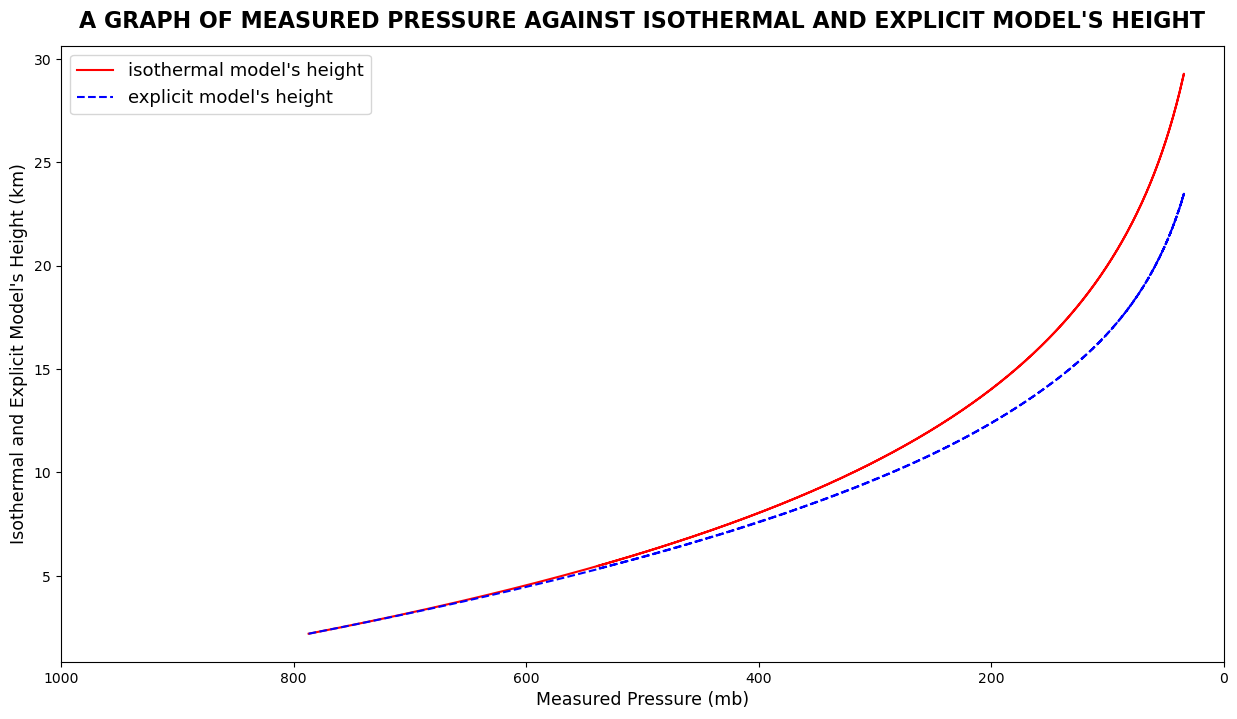

In [11]:
fig, ax = plt.subplots(figsize=(15,8))

# actual pressure against isothermal model's height
ax.plot(extracted_data['pressure (hPa)'], #1mb == 1hPa
        extracted_data['height-iso (m)']*0.001, #converted to km
        color='red', 
        label='isothermal model\'s height')

#actual pressure against explicit models's height
ax.plot(extracted_data['pressure (hPa)'], # 1mb == 1hPa
        extracted_data['height-exp (m)']*0.001,#converted to km
        color='blue',
        linestyle='dashed',
        label='explicit model\'s height')

ax.set_xlim(1000, 0)
ax.set_xlabel('Measured Pressure (mb)', fontsize=12.5)
ax.set_ylabel('Isothermal and Explicit Model\'s Height (km)',  fontsize=12.5)
ax.set_title('A GRAPH OF MEASURED PRESSURE AGAINST ISOTHERMAL AND EXPLICIT MODEL\'S HEIGHT',
             fontweight='bold', fontsize=16, pad=13)
ax.legend(prop={'size': 13})

fig.savefig('images/measured-pressure-against-models-height.jpg', dpi=100);

<h1 style="color:red;"><em>Plot Two</em></h1>

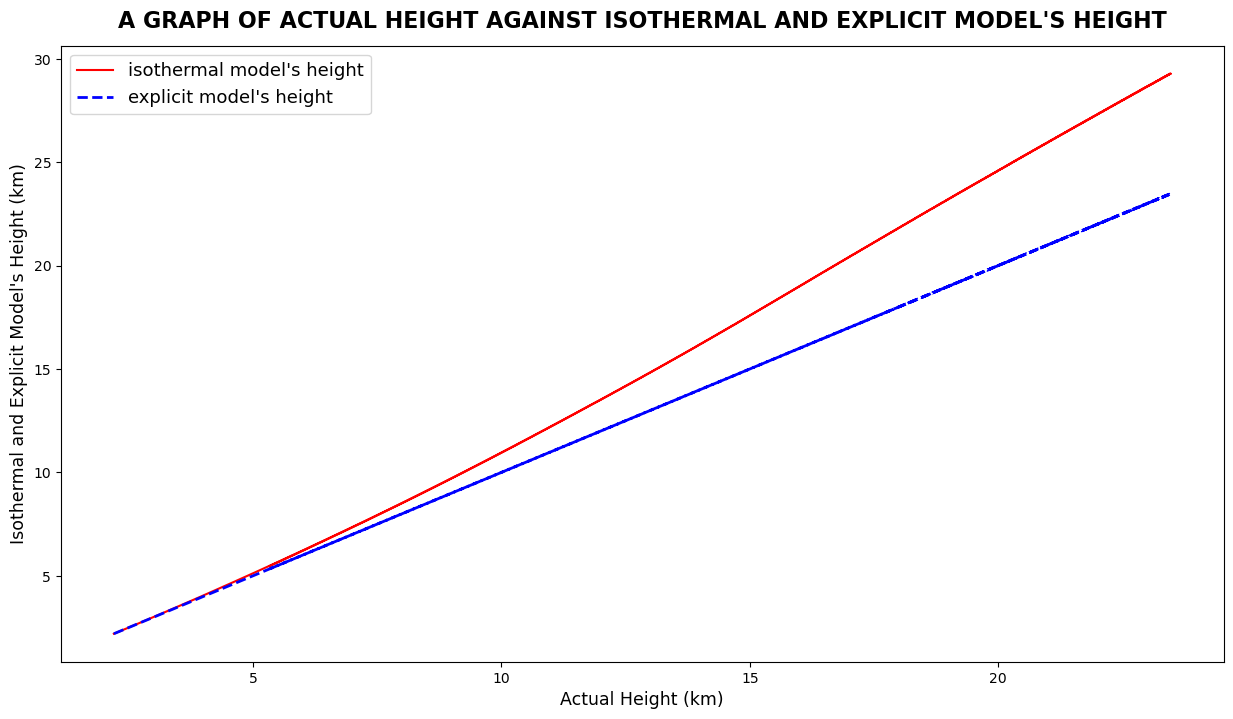

In [12]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(extracted_data['height (m)'] * 0.001, #convert to km
        extracted_data['height-iso (m)']*0.001, #convert to km
        color='red', 
        label='isothermal model\'s height')
ax.plot(extracted_data['height (m)']*0.001,#convert to km
        extracted_data['height-exp (m)']*0.001, #convert to km
        color='blue',
        linestyle='dashed',
        linewidth=2,
        label='explicit model\'s height')
ax.set_xlabel('Actual Height (km)', fontsize=12.5)
ax.set_ylabel('Isothermal and Explicit Model\'s Height (km)', fontsize=12.5)
ax.set_title('A GRAPH OF ACTUAL HEIGHT AGAINST ISOTHERMAL AND EXPLICIT MODEL\'S HEIGHT',
             fontweight='bold', fontsize=16, pad=13)
ax.legend(prop={'size': 13})


fig.savefig('images/actual-height-against-models-height.jpg', dpi=100);

<h1 style="color:red;"><em>Plot 3</em></h1>

In [13]:
#Differences in heights
diff_height_iso = extracted_data['height-iso (m)'] - extracted_data['height (m)']
diff_height_exp = extracted_data['height-exp (m)'] - extracted_data['height (m)']

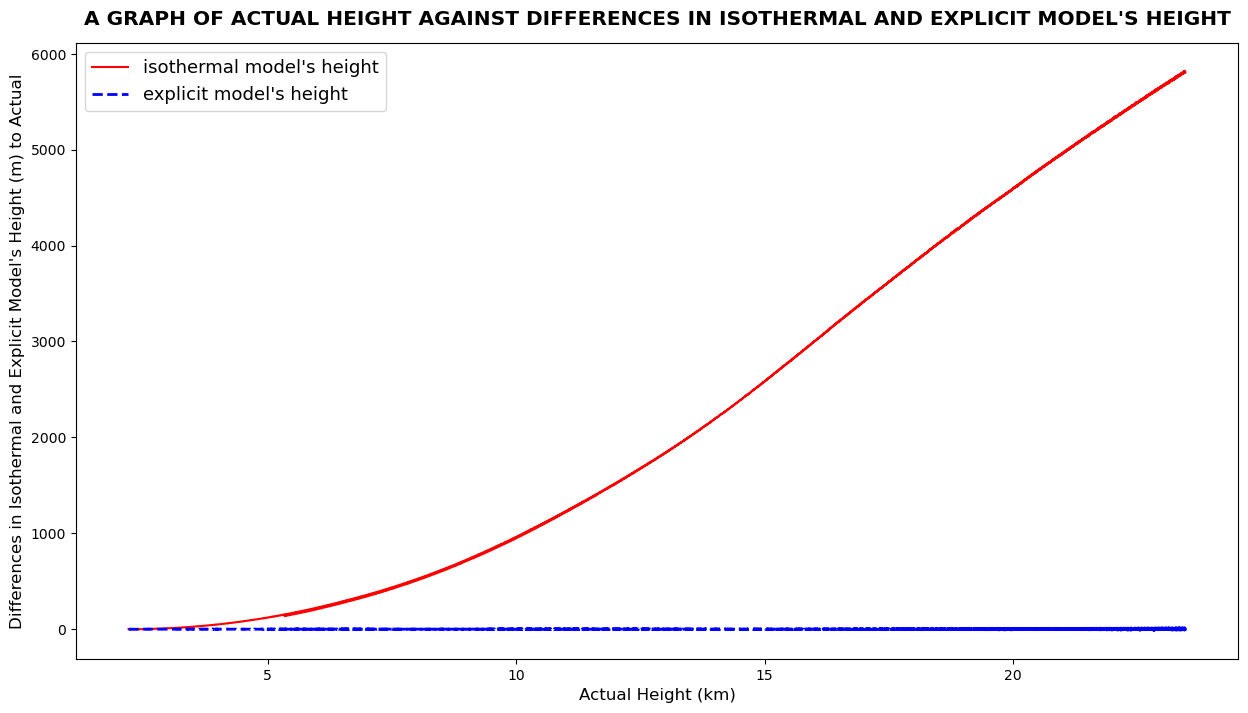

In [14]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(extracted_data['height (m)'] * 0.001, #convert to km
        diff_height_iso,
        color='red', 
        label='isothermal model\'s height')
ax.plot(extracted_data['height (m)']*0.001,#convert to km
        diff_height_exp, 
        color='blue',
        linestyle='dashed',
        linewidth=2,
        label='explicit model\'s height')
ax.set_xlabel('Actual Height (km)',
              fontsize=12)
ax.set_ylabel('Differences in Isothermal and Explicit Model\'s Height (m) to Actual', 
              fontsize=12)
ax.set_title('A GRAPH OF ACTUAL HEIGHT AGAINST DIFFERENCES IN ISOTHERMAL AND EXPLICIT MODEL\'S HEIGHT', 
             fontweight='bold', fontsize=14.5, pad=13)
ax.legend(prop={'size': 13})


fig.savefig('images/actual-height-against-models-height-differences.jpg', dpi=100);

<h1 style="color:black; text-align:center; font-size:30px;">QUESTIONS</h1>
<br>
<div>
    <ol>
        <li>Comparing the two models, at the top of the sounding (lowest pressure), which has the greatest calculated height?</li>
        <br>
        <li>Consider the assumptions used in the two models and the actual temperature as a function of altitude, explain the difference in calculated height between the two models. Why does temperature matter?</li>
        <br>
        <li>Does the difference between the two models increase, decrease, or stay about the same as altitude increases? Why?</li>
        <br>
        <li>Examining the plots comparing computed and actual height, how do you think the sounding retrieval program calculates height in this case?</li>
    </ol>
</div>

<hr>



<h1 style="color:black; text-align:center; font-size:30px;">ANSWERS</h1>

<ol>
    <li>The isothermal model has the greatest height</li>
    <br>
    <li>The difference in the height is as a result of temperature. For the isothermal model, because the temperature was constant at all levels, the height kept on increasing. For the explicit model, because the temperature was varying at each level(average temperatures), the increase wasn't that much as compared to the isothermal model</li>
    <br>
    <li>The difference between the two models increase. This is because the temperature for isothermal model was kept constant.</li>
    <br>
    <li>The sounding retrieval program calculates height using the explicit model, because it is similar to the actual height.</li>
</ol>

